In [1]:
import pandas as pd
import numpy as np
from datetime import *
import networkx as nx
from collections import *
from tqdm.notebook import tqdm

import dask
from multiprocessing.dummy import Pool
import multiprocessing
import matplotlib.pyplot as plt
import networkx.drawing
import pickle
import random as rd
import functionality_1 as fun_1
import functionality_3 as fun_3
from tabulate import tabulate

In [2]:
def dateparse(time_as_a_unix_timestamp):
    
    #input:unix time stamp
    #output: date
    #through this function we pass from the unix timestamp  to a readable date
    return pd.to_datetime(time_as_a_unix_timestamp, unit="s").strftime("%Y-%m-%d %H:%M")

In [3]:
class display(object):
    #it is a class that allows to visualize contemporarely more dataframe 
    #it's just for visualization
    
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

## 1. Data

In [4]:
#Answers to questions
a2q = pd.read_csv("sx-stackoverflow-a2q.txt", sep=" " ,header=None, names=["user_a", "user_b", "time"], parse_dates=["time"], date_parser=dateparse)

#Comments to answers
c2a = pd.read_csv("sx-stackoverflow-c2a.txt", sep=" " ,header=None, names=["user_a", "user_b", "time"], parse_dates=["time"], date_parser=dateparse)

#Comments to questions
c2q = pd.read_csv("sx-stackoverflow-c2q.txt", sep=" " ,header=None, names=["user_a", "user_b", "time"], parse_dates=["time"], date_parser=dateparse)

In the merged graph we have weighted link and we have decided to build these weights in the following way:
-  we have assigned a score of 1.0 to "Answers to questions"
-  we have assigned a score of 0.7 to "Comments to questions"
-  we have assigned a score of 0.4 to "Comments to answers"

The reasons are that we have thought that the answers to questions are the more relevant in the merged graph because they are possible solutions of user's question. Then a bit less important are comments to questions, but they could be relevant to clarify the question or specify something. Comments to answer are the least relevant, but we have not wanted to penalize them too much because in some situations they could be useful.

In [5]:
#Answers to questions
a2q["weights"] = 1

#Comments to answers
c2a["weights"] = 0.4

#Comments to questions
c2q["weights"] = 0.7

Nice and simultaneous visualization of the three file!

In [6]:
display("a2q", "c2a", "c2q")

,user_a,user_b,time,weights
0,9,8,2008-08-01 05:17:00,1
1,1,1,2008-08-01 06:56:00,1
2,13,1,2008-08-01 15:57:00,1
3,17,1,2008-08-01 19:07:00,1
4,48,2,2008-08-01 19:16:00,1
...,...,...,...,...
17823520,2773607,1048138,2016-03-06 12:16:00,1
17823521,6018278,1982354,2016-03-06 12:16:00,1
17823522,3187183,1404306,2016-03-06 12:17:00,1
17823523,6022341,1667278,2016-03-06 12:17:00,1


We have already assigned to each edge its weight based on what kind of edge is (if it is a link between an answer and a question or if it is one from a comment to an answer or if it is one from a comment to an question) so now we can just simply concatenate the three dataframe.

In [7]:
totDataframe = pd.concat([a2q, c2a, c2q])
totDataframe

,user_a,user_b,time,weights
0,9,8,2008-08-01 05:17:00,1.0
1,1,1,2008-08-01 06:56:00,1.0
2,13,1,2008-08-01 15:57:00,1.0
3,17,1,2008-08-01 19:07:00,1.0
4,48,2,2008-08-01 19:16:00,1.0
...,...,...,...,...
20268146,1177890,4917254,2016-03-06 14:06:00,0.7
20268147,3345375,4022289,2016-03-06 14:08:00,0.7
20268148,3507137,1801524,2016-03-06 14:09:00,0.7
20268149,5617035,4368648,2016-03-06 14:10:00,0.7


We have decided to filter the dataset through an interval of time of two years, from 2008 to 2010. Because in our opinion it is good tradeoff between deal with a smaller amount of data but sufficiently large interval to obtain significant result. We have focused on years during this filtering because a precision in second for our  analysis is not relevant.

In [21]:
totDataframe_2y = totDataframe[totDataframe.time.between("2008","2010")]
a2q_2y = a2q[a2q.time.between("2008","2010")]
c2q_2y = c2q[c2q.time.between("2008","2010")]
c2a_2y = c2a[c2a.time.between("2008","2010")]
display("a2q_2y", "c2a_2y", "c2q_2y", "totDataframe_2y")

,user_a,user_b,time,weights
0,9,8,2008-08-01 05:17:00,1
1,1,1,2008-08-01 06:56:00,1
2,13,1,2008-08-01 15:57:00,1
3,17,1,2008-08-01 19:07:00,1
4,48,2,2008-08-01 19:16:00,1
...,...,...,...,...
1286375,69148,192741,2009-10-14 06:13:00,1
1286376,13744,192741,2009-12-30 05:33:00,1
1308063,107156,41543,2009-08-07 20:18:00,1
1405111,105389,69769,2009-11-23 02:35:00,1


In [23]:
totDataframe_2y[totDataframe_2y.time.between("2008","2010")].iloc[:1000]

,user_a,user_b,time,weights
0,9,8,2008-08-01 05:17:00,1.0
1,1,1,2008-08-01 06:56:00,1.0
2,13,1,2008-08-01 15:57:00,1.0
3,17,1,2008-08-01 19:07:00,1.0
4,48,2,2008-08-01 19:16:00,1.0
...,...,...,...,...
995,192,380,2008-08-06 15:08:00,1.0
996,39,291,2008-08-06 15:15:00,1.0
997,383,476,2008-08-06 15:19:00,1.0
998,265,476,2008-08-06 15:26:00,1.0


You might also see that there are several answers/comments which the user answer do to themselves: since they are not too much we have decided to keep them. Also because they could be useful on Stackoverflow because maybe they represent users that clarify their question or they answers. 

In [53]:
#count repetitive loops
with_same_edge = len(totDataframe_2y[totDataframe_2y.user_a == totDataframe_2y.user_b])
without_same_edge = len(totDataframe_2y[totDataframe_2y.user_a == totDataframe_2y.user_b].drop_duplicates())

#how many loops
print(with_same_edge - without_same_edge)

1832


## Functionality 1 - Get the overall features of the graph

In [6]:
#filtering the dataset with the interval time that we have chosen
a2q_filter = a2q[a2q.time.between("2008","2010")]
c2a_filter = c2a[c2a.time.between("2008","2010")]
c2q_filter = c2q[c2q.time.between("2008","2010")]

In [7]:
#compute the first functionality for each file in input
#the user will choose interactively what file he wants to print
number_nodes_1, number_edges_1, directed_1, mean_1, density_1, sparse_1, degree_1, table_1 = fun_1.functionality_1(a2q_filter)
number_nodes_2, number_edges_2, directed_2, mean_2, density_2, sparse_2, degree_2, table_2 = fun_1.functionality_1(c2a_filter)
number_nodes_3, number_edges_3, directed_3, mean_3, density_3, sparse_3, degree_3, table_3 = fun_1.functionality_1(c2q_filter)

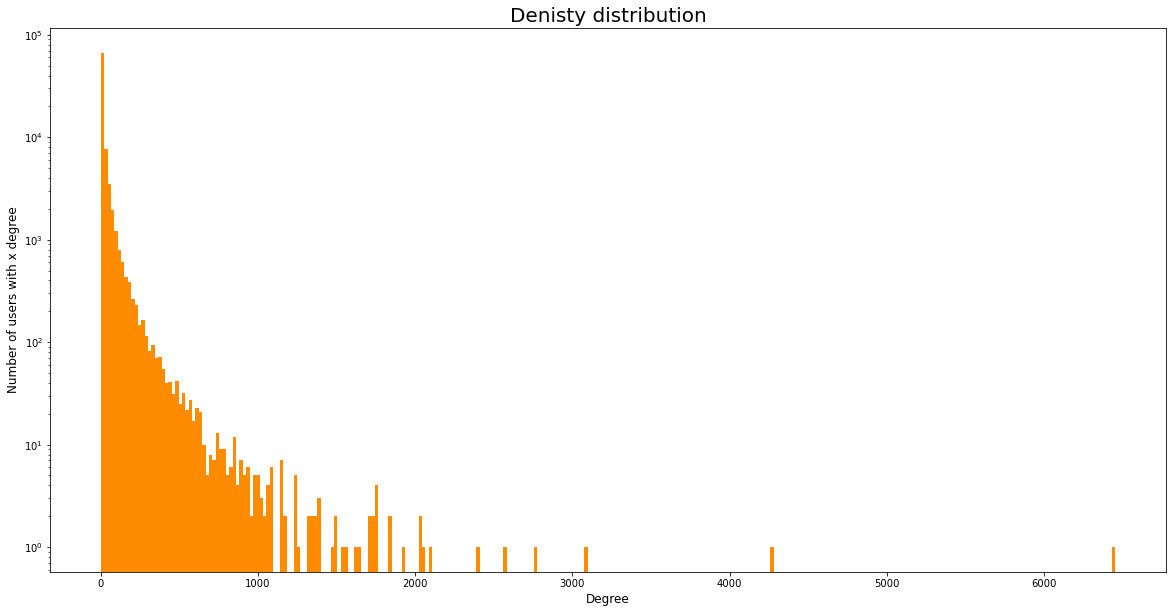

In [8]:
fun_1.fig(degree_1)

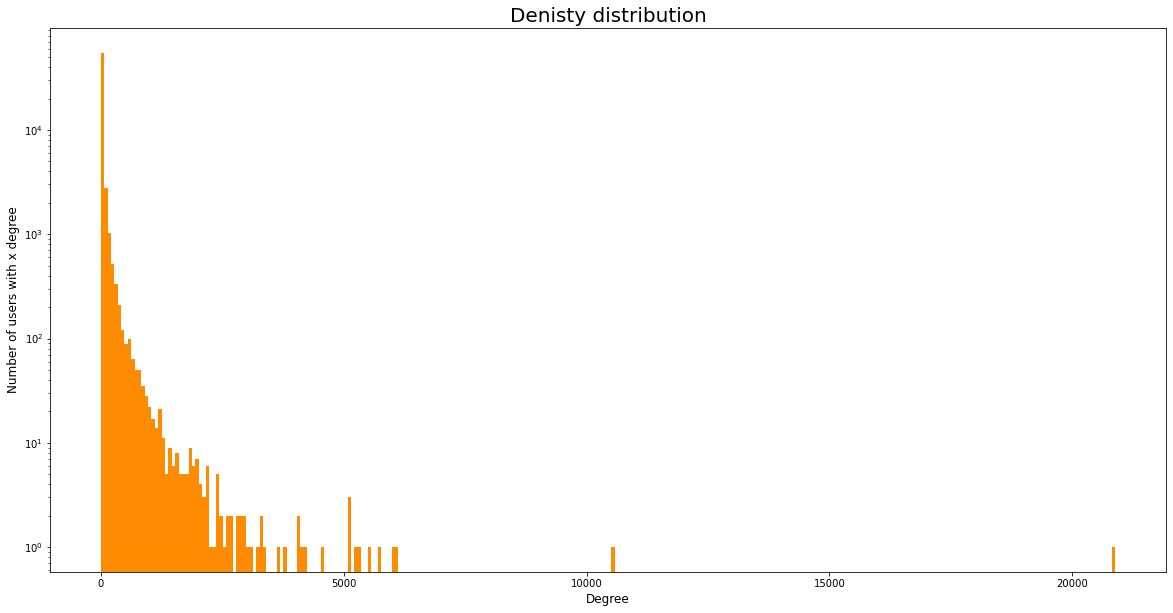

In [9]:
fun_1.fig(degree_2)

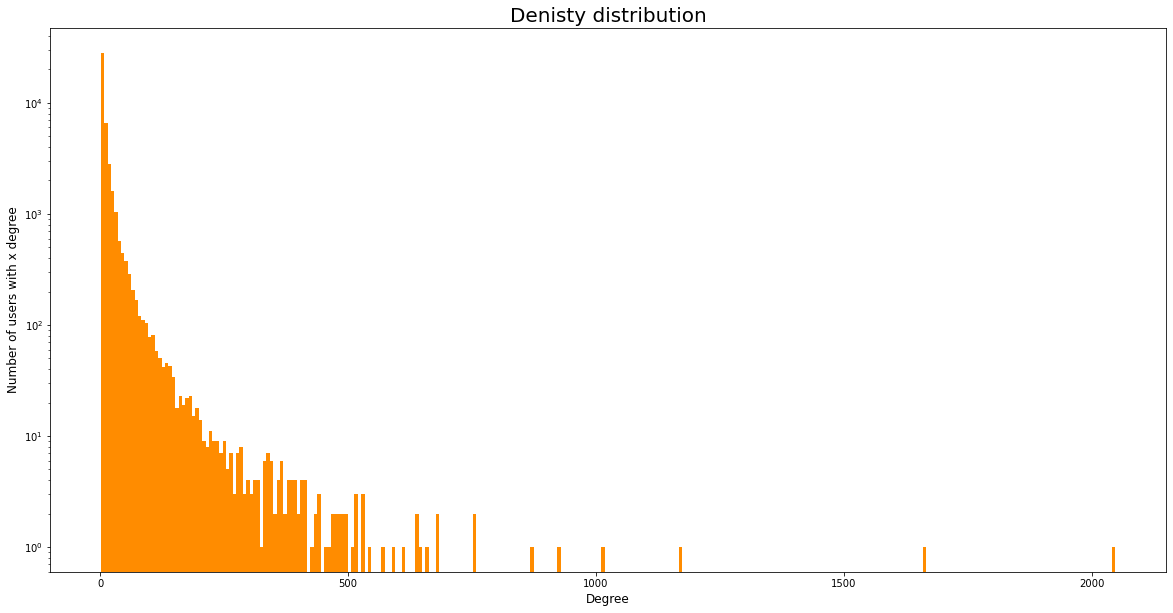

In [10]:
fun_1.fig(degree_3)

In [11]:
print(tabulate(table_1, headers = 'firstrow', tablefmt = 'fancy_grid'))

╒══════════════════════════════╤════════════════════════════════════════════════╕
│ Info requested               │ Answers                                        │
╞══════════════════════════════╪════════════════════════════════════════════════╡
│ File                         │ user_a  user_b                time  weights    │
│                              │ 0       9       8 2008-08-01 05:17:00        1 │
│                              │ 1       1       1 2008-08-01 06:56:00        1 │
│                              │ 2      13       1 2008-08-01 15:57:00        1 │
│                              │ 3      17       1 2008-08-01 19:07:00        1 │
│                              │ 4      48       2 2008-08-01 19:16:00        1 │
├──────────────────────────────┼────────────────────────────────────────────────┤
│ Directed or Undirected?      │ directed                                       │
├──────────────────────────────┼────────────────────────────────────────────────┤
│ N. users      

In [12]:
print(tabulate(table_2, headers = 'firstrow', tablefmt = 'fancy_grid'))

╒══════════════════════════════╤═════════════════════════════════════════════════╕
│ Info requested               │ Answers                                         │
╞══════════════════════════════╪═════════════════════════════════════════════════╡
│ File                         │ user_a   user_b                time  weights    │
│                              │ 0       1       91 2008-09-06 15:07:00      0.4 │
│                              │ 1       3       91 2008-09-06 15:09:00      0.4 │
│                              │ 2     380      350 2008-09-06 15:42:00      0.4 │
│                              │ 3    4642     2257 2008-09-06 20:51:00      0.4 │
│                              │ 4    4642  1324220 2008-09-06 21:15:00      0.4 │
├──────────────────────────────┼─────────────────────────────────────────────────┤
│ Directed or Undirected?      │ directed                                        │
├──────────────────────────────┼─────────────────────────────────────────────────┤
│ N.

In [13]:
print(tabulate(table_3, headers = 'firstrow', tablefmt = 'fancy_grid'))

╒══════════════════════════════╤════════════════════════════════════════════════╕
│ Info requested               │ Answers                                        │
╞══════════════════════════════╪════════════════════════════════════════════════╡
│ File                         │ user_a  user_b                time  weights    │
│                              │ 0    4550    4550 2008-09-06 19:26:00      0.7 │
│                              │ 1     242     184 2008-09-06 20:38:00      0.7 │
│                              │ 2    4213    4946 2008-09-07 06:15:00      0.7 │
│                              │ 3      91      91 2008-09-07 06:18:00      0.7 │
│                              │ 4    2658    1874 2008-09-07 07:18:00      0.7 │
├──────────────────────────────┼────────────────────────────────────────────────┤
│ Directed or Undirected?      │ directed                                       │
├──────────────────────────────┼────────────────────────────────────────────────┤
│ N. users      

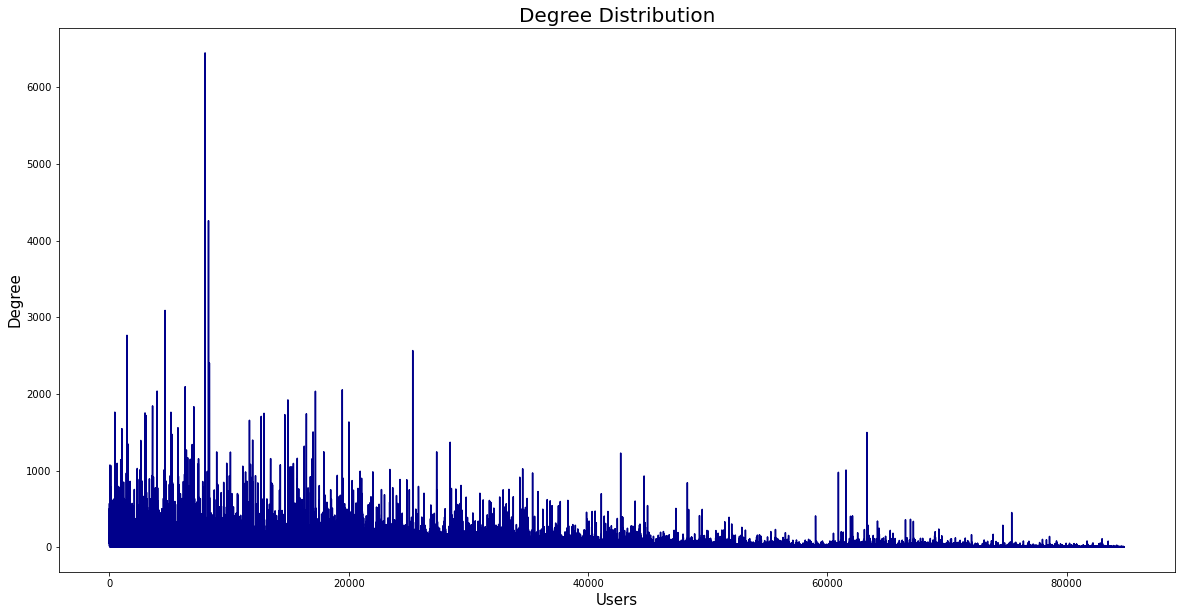

In [14]:
fun_1.fig_plot(degree_1)

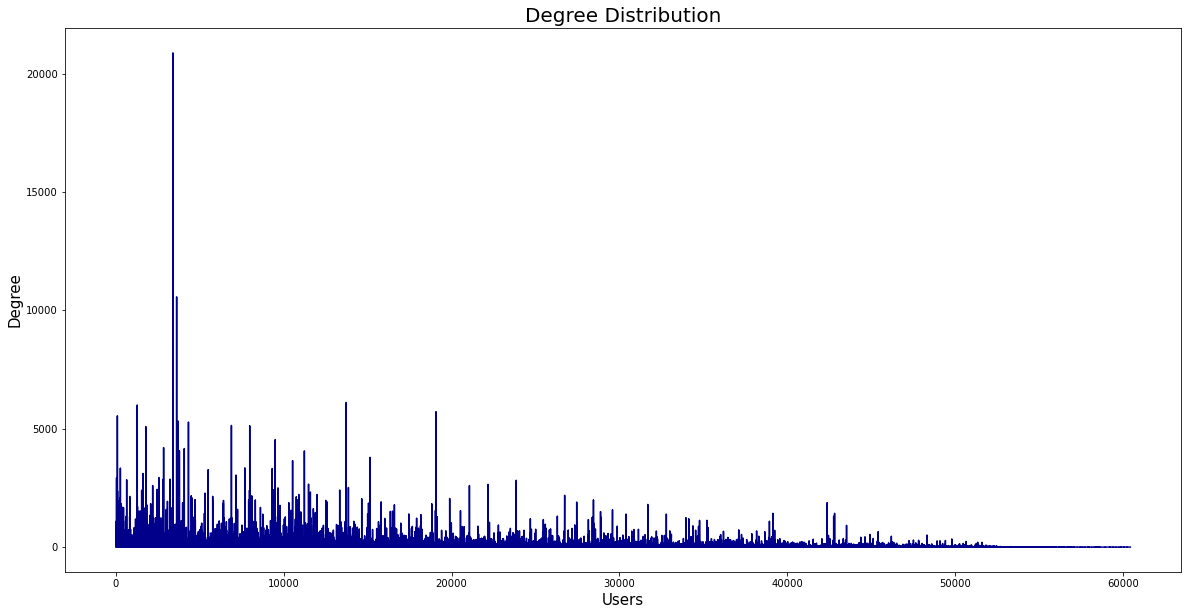

In [15]:
fun_1.fig_plot(degree_2)

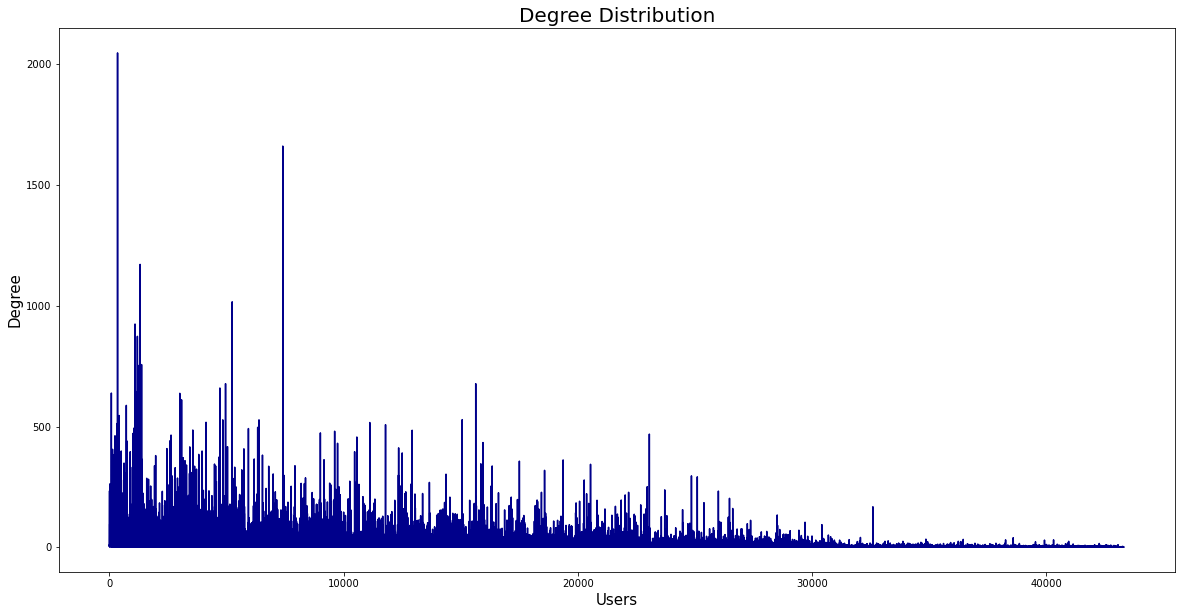

In [16]:
fun_1.fig_plot(degree_3)

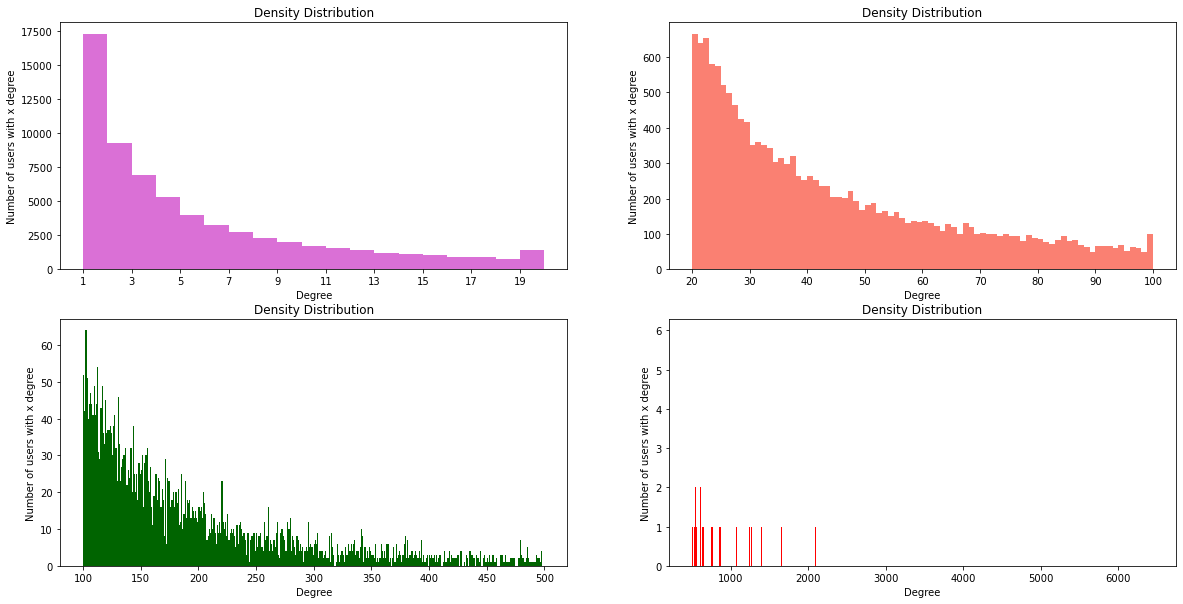

In [17]:
fun_1.fig_hist(degree_1)

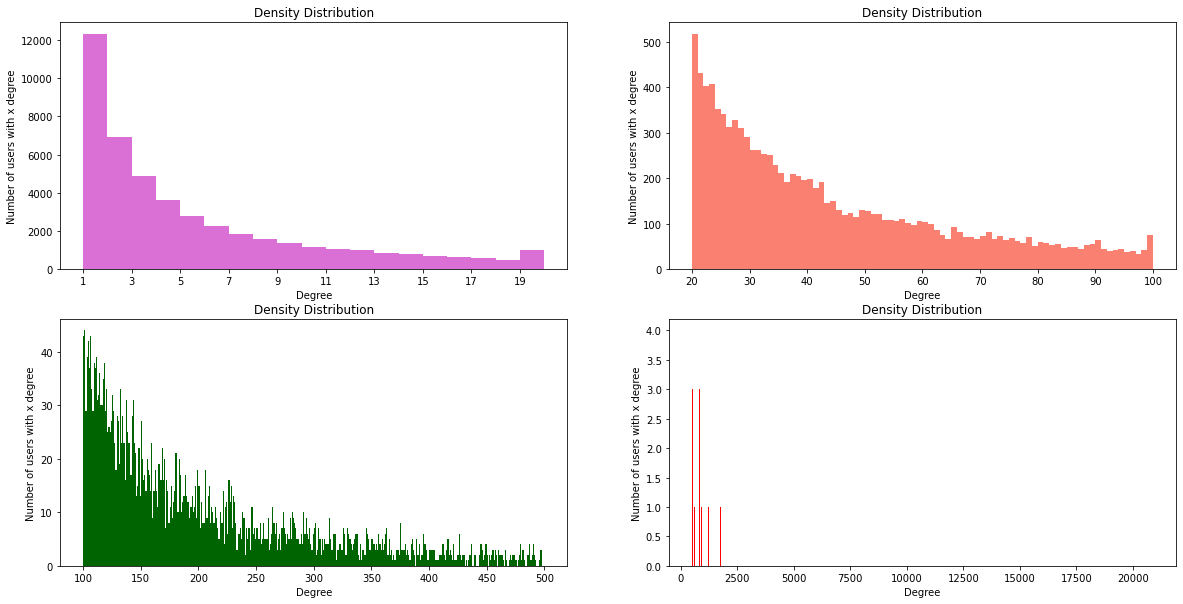

In [18]:
fun_1.fig_hist(degree_2)

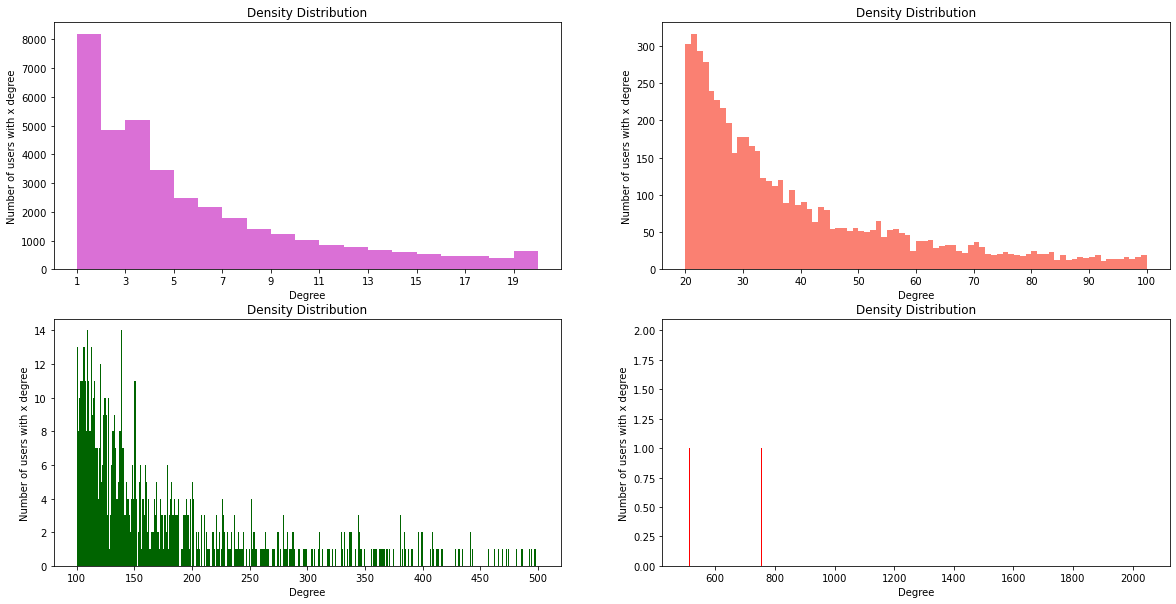

In [19]:
fun_1.fig_hist(degree_3)

In [ ]:
def app():
    end = 0
    while (end == 0):

        #choose what functionality
        user = int(input("Welcome user, what functionality do you want: "))

        if (user == 1):

            #choose what file
            scelta = input("What file do you want to analyze?: ")
            if scelta == "a2q":

                number_nodes_1, number_edges_1, directed_1, mean_1, density_1, sparse_1, degree_1, table_1 = fun_1.functionality_1(a2q_filter)
                print(tabulate(table_1, headers='firstrow', tablefmt='fancy_grid'))
                print("We want to visualize how many users have a certain degree")
                fun_1.fig(degree_1)
                print("We want to go deeper in the density distribution")
                fun_1.fig_hist(degree_1)
                print("We want to visualize for each user how many degree it has")
                fun_1.fig_plot(degree_1)

            elif scelta == "c2a":

                number_nodes_2, number_edges_2, directed_2, mean_2, density_2, sparse_2, degree_2, table_2 = fun_1.functionality_1(c2a_filter)
                print(tabulate(table_2, headers='firstrow', tablefmt='fancy_grid'))
                print("We want to visualize how many users have a certain degree")
                fun_1.fig(degree_2)
                print("We want to go deeper in the density distribution")
                fun_1.fig_hist(degree_2)
                print("We want to visualize for each user how many degree it has")
                fun_1.fig_plot(degree_2)


            else:

                number_nodes_3, number_edges_3, directed_3, mean_3, density_3, sparse_3, degree_3, table_3 = fun_1.functionality_1(c2q_filter)
                print(tabulate(table_3, headers='firstrow', tablefmt='fancy_grid'))
                print("We want to visualize how many users have a certain degree")
                fun_1.fig(degree_3)
                print("We want to go deeper in the density distribution")
                fun_1.fig_hist(degree_3)
                print("We want to visualize for each user how many degree it has")
                fun_1.fig_plot(degree_3)

            end = 1



        if (user == 2):

            print("result of func_2")
            print("Functionality 2 - Find the best users!")
            end = 1

        if (user == 3):
            print("Functionality 3 - Shortest Ordered Route")
            print("result of func_3")
            end = 1

In [ ]:
p_start

In [27]:

def starting_nodes(df):
    #array of nodes of graph a2q
    nodi_grafo = pd.concat([df["user_a"], df["user_b"]], axis = 0).drop_duplicates().array
    start_p = rd.choice(nodi_grafo)
    end_p = rd.choice(nodi_grafo)
    return start_p, end_p

4557888

## Functionality 3

In [ ]:

def starting_nodes(df):
    #array of nodes of graph a2q
    nodi_grafo = pd.concat([df["user_a"], df["user_b"]], axis = 0).drop_duplicates().array
    start_p = rd.choice(nodi_grafo)
    end_p = rd.choice(nodi_grafo)
    return start_p, end_p

In [10]:
out_graph_1, final_path_1, lunghezza_1 = func_3(totDataframe,[91,1], 45, 1269, "2008", "2010")

KeyboardInterrupt: 

In [ ]:
2+5

In [8]:
out_graph_2, final_path_2, lunghezza_2 = fun_3.func_3(totDataframe,[1, 67], 13, 83, "2008", "2010")

KeyboardInterrupt: 

In [ ]:
out_graph_3, final_path_3, lunghezza_3 = fun_3.func_3(totDataframe,[9,72,95,434,307,91,1,233], 22, 396, "2008", "2010")

In [ ]:
out_graph_4, final_path_4, lunghezza_4 = fun_3.func_3(totDataframe,[67,380,3397], 1, 13615, "2008", "2010")

In [ ]:
[9,72,95,434,307,91,1,233], 22, 396,

In [19]:
functionality_3([1, 67], 13, 83, time_start, time_end)

([13 -> 1 ::::: weight = 1.0 ::::: time: 2008-08-01 15:57:00,
  1 -> 67 ::::: weight = 1.0 ::::: time: 2008-08-04 15:04:00,
  67 -> 83 ::::: weight = 1.0 ::::: time: 2008-08-05 04:22:00],
 3.0)

In [22]:
g = make_graph(totDataframe_filter)


In [24]:
q = functionality_3([9,72,95,434,307,91,1,233], 22, 396, time_start, time_end)


In [33]:
q

([22 -> 9 ::::: weight = 1.0 ::::: time: 2008-08-05 12:54:00,
  9 -> 72 ::::: weight = 1.0 ::::: time: 2008-08-02 00:47:00,
  72 -> 95 ::::: weight = 1.0 ::::: time: 2008-08-05 22:19:00,
  95 -> 434 ::::: weight = 1.0 ::::: time: 2008-08-06 15:06:00,
  434 -> 307 ::::: weight = 1.0 ::::: time: 2008-08-06 02:32:00,
  307 -> 91 ::::: weight = 1.0 ::::: time: 2008-08-05 00:38:00,
  91 -> 1 ::::: weight = 1.0 ::::: time: 2008-08-02 04:46:00,
  1 -> 233 ::::: weight = 1.0 ::::: time: 2008-08-13 10:30:00,
  233 -> 396 ::::: weight = 1.0 ::::: time: 2008-08-12 08:23:00],
 9.0)

In [26]:
functionality_3([67,380,3397], 1, 13615, time_start, time_end)

'Not possible'

In [29]:
f = functionality_3([91,1], starting_nodes(totDataframe_filter)[0] , starting_nodes(totDataframe_filter)[1], time_start, time_end)
f

([45 -> 432 ::::: weight = 1.0 ::::: time: 2008-08-06 01:49:00,
  432 -> 1 ::::: weight = 2.0 ::::: time: 2008-08-16 00:40:00,
  1 -> 91 ::::: weight = 3.0 ::::: time: 2008-08-13 06:13:00,
  91 -> 1 ::::: weight = 1.0 ::::: time: 2008-08-02 04:46:00,
  1 -> 91 ::::: weight = 1.0 ::::: time: 2008-08-13 06:13:00,
  91 -> 1269 ::::: weight = 2.0 ::::: time: 2008-08-14 15:11:00],
 10.0)

In [34]:
q = functionality_3([91,1], 45, 1269, time_start, time_end)
q

([45 -> 432 ::::: weight = 1.0 ::::: time: 2008-08-06 01:49:00,
  432 -> 1 ::::: weight = 2.0 ::::: time: 2008-08-16 00:40:00,
  1 -> 91 ::::: weight = 3.0 ::::: time: 2008-08-13 06:13:00,
  91 -> 1 ::::: weight = 1.0 ::::: time: 2008-08-02 04:46:00,
  1 -> 91 ::::: weight = 1.0 ::::: time: 2008-08-13 06:13:00,
  91 -> 1269 ::::: weight = 2.0 ::::: time: 2008-08-14 15:11:00],
 10.0)

In [36]:
g.nodes[91]

[30 -> 91 ::::: weight = 1.0 ::::: time: 2008-08-02 01:08:00,
 50 -> 91 ::::: weight = 1.0 ::::: time: 2008-08-02 02:58:00,
 39 -> 91 ::::: weight = 1.0 ::::: time: 2008-08-02 03:02:00,
 96 -> 91 ::::: weight = 1.0 ::::: time: 2008-08-02 03:05:00,
 91 -> 1 ::::: weight = 1.0 ::::: time: 2008-08-02 04:46:00,
 91 -> 62 ::::: weight = 1.0 ::::: time: 2008-08-02 05:18:00,
 48 -> 91 ::::: weight = 1.0 ::::: time: 2008-08-02 05:20:00,
 34 -> 91 ::::: weight = 1.0 ::::: time: 2008-08-02 05:22:00,
 71 -> 91 ::::: weight = 1.0 ::::: time: 2008-08-02 05:31:00,
 55 -> 91 ::::: weight = 1.0 ::::: time: 2008-08-02 06:17:00,
 91 -> 91 ::::: weight = 1.0 ::::: time: 2008-08-02 06:49:00,
 91 -> 91 ::::: weight = 1.0 ::::: time: 2008-08-02 06:49:00,
 91 -> 109 ::::: weight = 1.0 ::::: time: 2008-08-02 07:47:00,
 40 -> 91 ::::: weight = 1.0 ::::: time: 2008-08-02 08:10:00,
 91 -> 71 ::::: weight = 1.0 ::::: time: 2008-08-02 08:38:00,
 49 -> 91 ::::: weight = 1.0 ::::: time: 2008-08-02 08:49:00,
 100 -> 

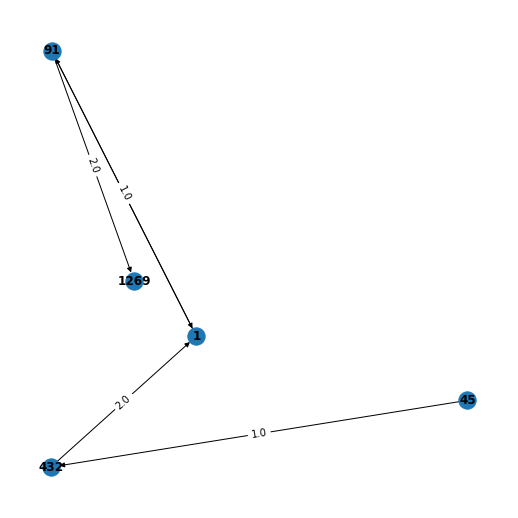

In [32]:
g_2 = GRAPH()
for i in f[0]:
    g_2.add_edge_object(i)

g_2.print_graph()

## prova

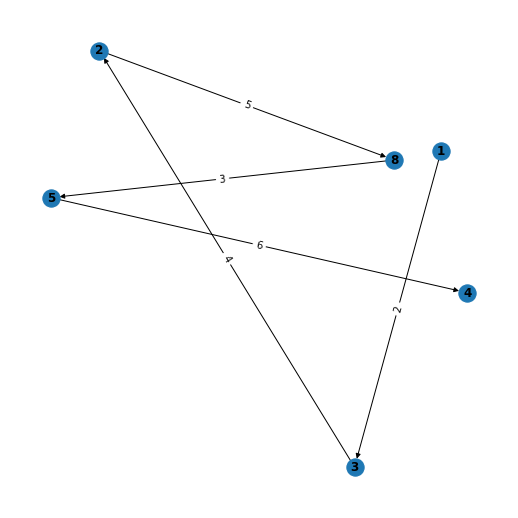

In [265]:
t2 = GRAPH()
t2.add_edge(from_n=1,to_n=3, time="438", w=2)
t2.add_edge(from_n=3,to_n=2, time="438", w=4)
t2.add_edge(from_n=2,to_n=8, time="438", w=5)
t2.add_edge(from_n=8,to_n=5, time="438", w=3)
t2.add_edge(from_n=5,to_n=4, time="438", w=6)
t2.add_node(6)
t2.print_graph()

In [13]:
t2 = GRAPH()
t2.add_edge(from_n=1,to_n=3, time="438", w=2)
t2.add_edge(from_n=3,to_n=2, time="438", w=4)
t2.add_edge(from_n=2,to_n=8, time="438", w=10)
t2.add_edge(from_n=8,to_n=5, time="438", w=3)
t2.add_edge(from_n=5,to_n=4, time="438", w=6)
t2.add_edge(from_n=2,to_n=1, time="438", w=1)
t2.add_edge(from_n=1,to_n=8, time="438", w=0.5)
t2.add_node(6)
#t2.print_graph()

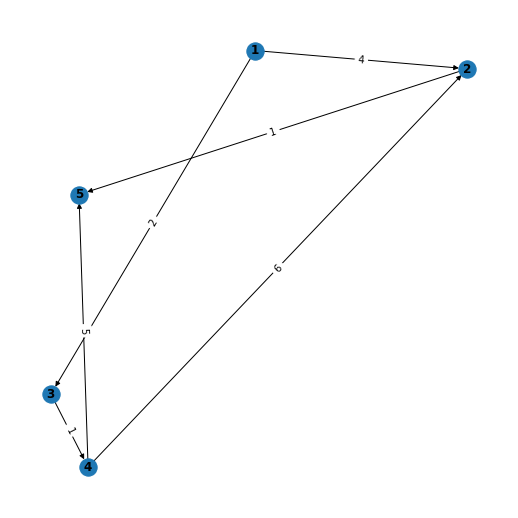

In [271]:
t2 = GRAPH()
t2.add_edge(from_n=1,to_n=3, time="438", w=2)
t2.add_edge(from_n=1,to_n=2, time="438", w=4)
t2.add_edge(from_n=3,to_n=4, time="438", w=1)
t2.add_edge(from_n=4,to_n=2, time="438", w=6)
t2.add_edge(from_n=2,to_n=5, time="438", w=1)
t2.add_edge(from_n=4,to_n=5, time="438", w=5)
t2.add_node(6)
t2.print_graph()

In [272]:
    p = [1,2,6]
    final_path = []
    for i in range(0, len(p)-1):
        new_g, dist = dijkstra(p[i], t2)

        if(new_g.is_linked_from(p[i], p[i+1])):
            final_path.append(new_g.get_edge(p[i], p[i+1]))
        else:
            temp = []
            try:
                prec = [el for el in new_g.nodes[p[i+1]] if el.from_n != p[i+1]][0]
            except IndexError:
                print("Not possible")
                break

            temp.append(prec)

            while(not prec.from_n == p[i]):



                punt = [el for el in new_g.nodes[prec.from_n] if el.from_n != prec.from_n][0]

                temp.append(punt)

                prec = punt

            temp.reverse()
            final_path.extend(temp)
            
    
    lunghezza = sum([edge.w for edge in final_path])

    print(final_path)
    print(lunghezza)


Not possible
[1 -> 2 ::::: weight = 4 ::::: time: 438]
4
